In [146]:
import numpy as np
import scipy
from scipy import fftpack, ndimage
from sklearn import neighbors, svm
from sklearn.neighbors import KNeighborsClassifier
from skimage.filter import threshold_otsu
from skimage import data, io, color, transform, exposure
from skimage.transform import resize as rs
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
from PIL import Image
import scipy.misc



%matplotlib inline
# notebook
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = (32.0, 24.0)
pylab.rcParams['font.size'] = 24

/home/mnazaal/.local/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


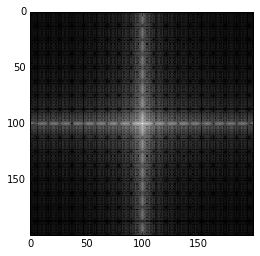

In [2]:
#thresholding check

imgS = color.rgb2gray(io.imread("ct1.png"))
thresh = threshold_otsu(imgS)
binary = imgS > thresh
f1 = fftpack.fft2(binary)
f2 = fftpack.fftshift(f1)
ax_im = io.imshow(np.log(np.abs(f2) + 1))
scipy.misc.toimage(np.log(np.abs(f2)), cmin=0, cmax=255).save('outfile2.png')

In [91]:
# loading the data and doing the 2D Fourier transform on it
train_amt = 10
test_amt = 2

# real valied matrices which represent the images
trainS = [io.imread("S" + str(i+1) + ".GIF") for i in range(train_amt)]
trainT = [io.imread("T" + str(i+1) + ".GIF") for i in range(train_amt)]
trainV = [io.imread("V" + str(i+1) + ".GIF") for i in range(train_amt)]

#thresholding
def thresholding(image):
    threshold = threshold_otsu(image)
    binary = image > threshold
    return binary

# compelx valued matrices which represent the FTs of the images
trainSFourier = [fftpack.fft2(trainS[i]) for i in range(train_amt)]
trainTFourier = [fftpack.fft2(trainT[i]) for i in range(train_amt)]
trainVFourier = [fftpack.fft2(trainV[i]) for i in range(train_amt)]

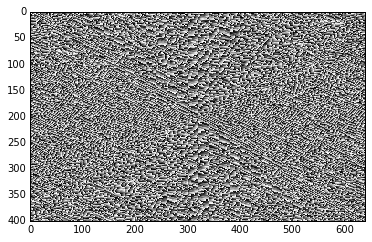

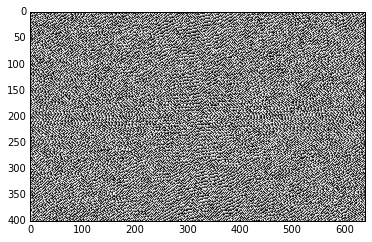

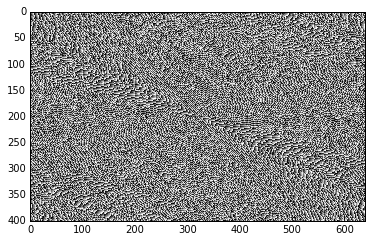

In [4]:
# Viewing the Fourier phase space of S,T,V respectively

ax_im = io.imshow(np.angle(fftpack.fftshift(trainSFourier[0])))
io.show()
ax_im = io.imshow(np.angle(fftpack.fftshift(trainTFourier[0])))
io.show()
ax_im = io.imshow(np.angle(fftpack.fftshift(trainVFourier[0])))
io.show()

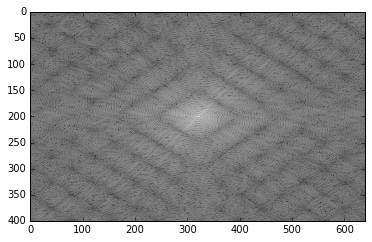

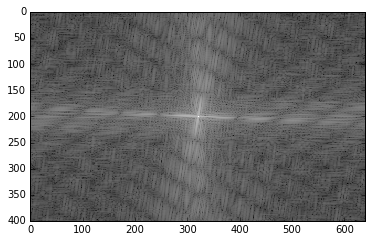

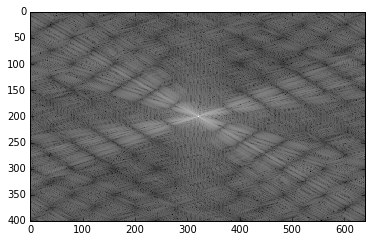

In [6]:
# Viewing the Fourier amplitude space of S,T,V respectively
ax_im = io.imshow(fftpack.fftshift(np.log(np.abs(trainSFourier[0]) +1 )))
io.show()
ax_im = io.imshow(fftpack.fftshift(np.log(np.abs(trainTFourier[0]) +1 )))
io.show()
ax_im = io.imshow(fftpack.fftshift(np.log(np.abs(trainVFourier[0]) + 1 )))
io.show()

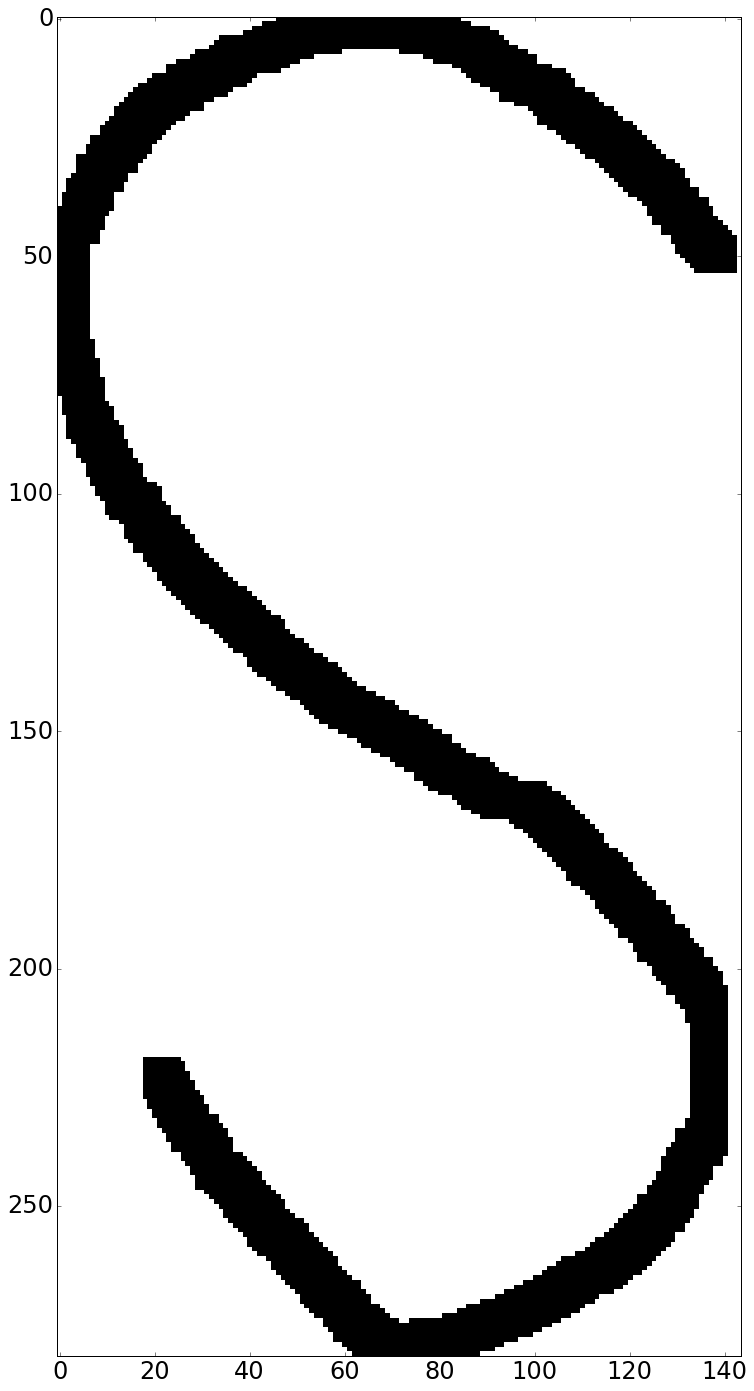

In [32]:
def cropper(image):
    ymax, ymin, xmax, xmin = 1000000, 1000000, 1000000, 1000000

    
    for i in range(0, image.shape[0]):
        for j in range(1, image.shape[1]):
            if image[i, j] < image[i, j-1]:
                ymax = i  

    for i in range(image.shape[0], 0, -1):
        for j in range(1, image.shape[1]):
            if image[i-1, j] < image[i-1, j-1]:
                ymin = i

    for j in range(0, image.shape[1]):
        for i in range(1, image.shape[0]):
            if image[i, j] < image[i, j-1]:
                xmax = j
            
    for j in range(image.shape[1], 0, -1):
        for i in range(1, image.shape[0]):
            if image[i-1, j-1] < image[i-1, j-2]:
                xmin = j
            
    cropped_image = image[ymin:ymax, xmin:xmax+10]
    return cropped_image

ax_im = io.imshow(cropper(trainS[3]))

In [8]:
# Crop the test sample images

trainScropped = list(map(cropper, trainS))
trainTcropped = list(map(cropper, trainT))
trainVcropped = list(map(cropper, trainV))

In [9]:
def getAverageRatio(imageList):
    ratios = []
    for i in range(0, len(imageList)):
        ratios.append(imageList[i].shape)
    floatAvg = tuple(np.mean(ratios, axis = 0))
    intAvg = (int(floatAvg[0]), int(floatAvg[1]))
    return intAvg
    
# Resize all images of each character to the average size
def imageResizer(imageList):
    avgRatio = getAverageRatio(imageList)
    for i in range(0, len(imageList)):
        imageList[i] = rs(imageList[i], avgRatio)
    return imageList

# testing to see whether all image sizes are same
x = imageResizer(trainTcropped)
for i in range(0, len(x)):
    print(x[i].shape)

(223, 231)
(223, 231)
(223, 231)
(223, 231)
(223, 231)
(223, 231)
(223, 231)
(223, 231)
(223, 231)
(223, 231)


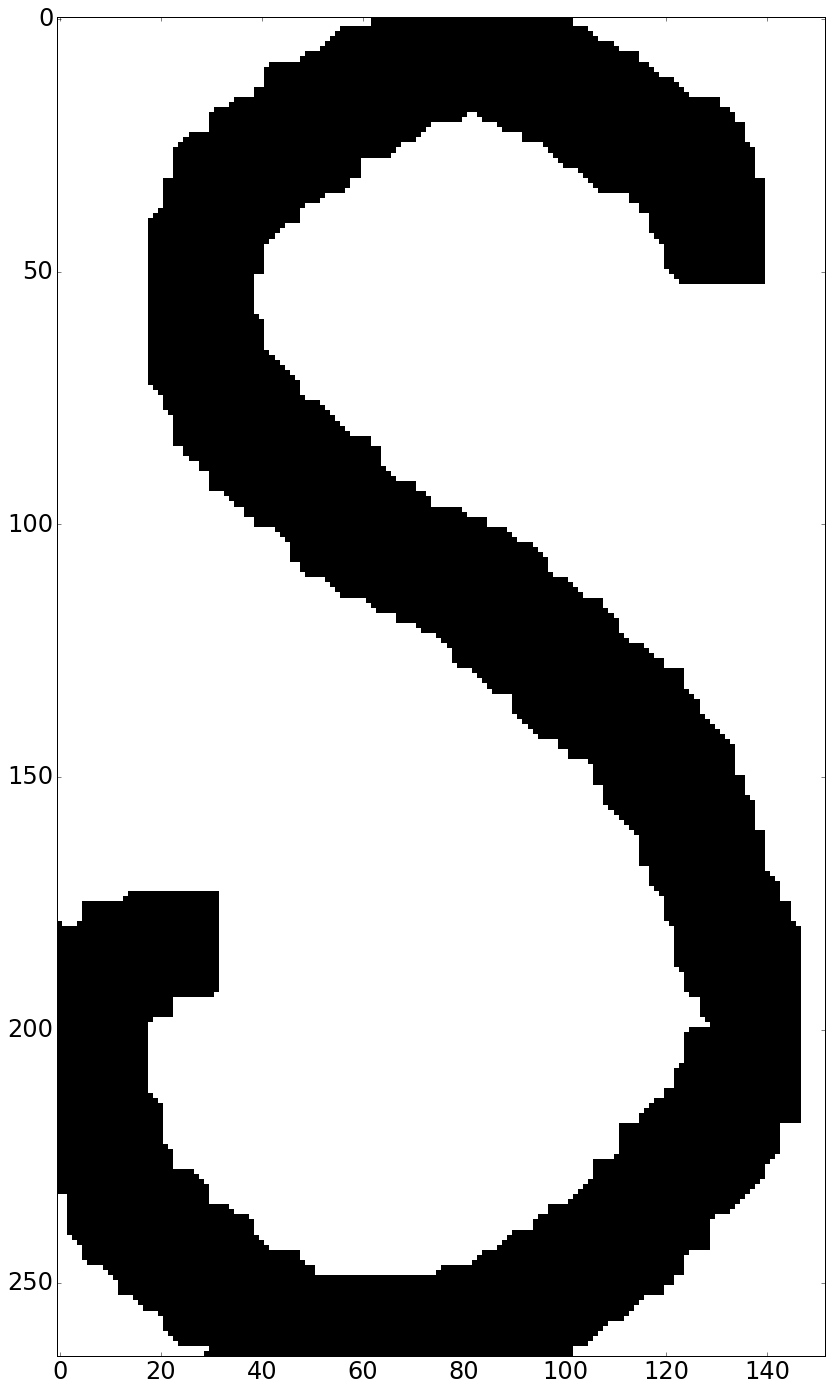

In [97]:
# cropping and resizing everything to their average ratios

trainScroppedAndResized = imageResizer(trainScropped)
trainTcroppedAndResized = imageResizer(trainTcropped)
trainVcroppedAndResized = imageResizer(trainVcropped)

trainScroppedAndResized = list(map(thresholding, trainScroppedAndResized))
trainTcroppedAndResized = list(map(thresholding, trainTcroppedAndResized))
trainVcroppedAndResized = list(map(thresholding, trainVcroppedAndResized))

ax_im = io.imshow(trainScroppedAndResized[6])
io.show()

In [98]:
trainSFourierNew = [fftpack.fftshift(np.fft.fft2(trainScroppedAndResized[i])) for i in range(train_amt)]
trainTFourierNew = [fftpack.fftshift(np.fft.fft2(trainTcroppedAndResized[i])) for i in range(train_amt)]
trainVFourierNew = [fftpack.fftshift(np.fft.fft2(trainVcroppedAndResized[i])) for i in range(train_amt)]

In [136]:
#SQUARE FITLER
def boxpass(fourierDomain):
    # extracts a rectangular region from Fourier space
    xmid = fourierDomain.shape[0] / 2
    ymid = fourierDomain.shape[1] / 2
    s = 0
    for x in range(0, int(xmid*2) - 1):
        for y in range(0, int(ymid*2) - 1):
            s += 0.0001*(fourierDomain[x, y]**2)**0.5
    return s

def nopass(fourierDomain):
    s=0
    for x in range(0, fourierDomain.shape[0]-1):
        for y in range(0, fourierDomain.shape[1]-1):
            s += 0.0001*(fourierDomain[x,y]**2)**0.5
    return s

#def circlepass(fourierDomain):
    # extracts a circular region from Fourier space
#    s = 0
#    for r in range(0, R):

In [139]:
#FEATURE EXTRACTION
feature1 = np.array([boxpass(np.angle(trainSFourierNew[i])) for i in range(train_amt)])
feature2 = np.array([boxpass(np.log(np.abs(trainSFourierNew[i]) + 1)) for i in range(train_amt)])
feature3 = np.array([boxpass(np.angle(trainTFourierNew[i])) for i in range(train_amt)])
feature4 = np.array([boxpass(np.log(np.abs(trainTFourierNew[i]) + 1)) for i in range(train_amt)])
feature5 = np.array([boxpass(np.angle(trainVFourierNew[i])) for i in range(train_amt)])
feature6 = np.array([boxpass(np.log(np.abs(trainVFourierNew[i]) + 1)) for i in range(train_amt)])

#SHOULDVE NAME THEM AS BELOW
""""
trainSfeature1 = np.array([boxpass(np.angle(trainSFourierNew[i])) for i in range(train_amt)])
trainSfeature2 = np.array([boxpass(np.log(np.abs(trainSFourierNew[i]) + 1)) for i in range(train_amt)])
trainTfeature1 = np.array([boxpass(np.angle(trainTFourierNew[i])) for i in range(train_amt)])
trainTfeature2 = np.array([boxpass(np.log(np.abs(trainTFourierNew[i]) + 1)) for i in range(train_amt)])
trainVfeature1 = np.array([boxpass(np.angle(trainVFourierNew[i])) for i in range(train_amt)])
trainVfeature2 = np.array([boxpass(np.log(np.abs(trainVFourierNew[i]) + 1)) for i in range(train_amt)])
"""
#well too late now

'"\ntrainSfeature1 = np.array([boxpass(np.angle(trainSFourierNew[i])) for i in range(train_amt)])\ntrainSfeature2 = np.array([boxpass(np.log(np.abs(trainSFourierNew[i]) + 1)) for i in range(train_amt)])\ntrainTfeature1 = np.array([boxpass(np.angle(trainTFourierNew[i])) for i in range(train_amt)])\ntrainTfeature2 = np.array([boxpass(np.log(np.abs(trainTFourierNew[i]) + 1)) for i in range(train_amt)])\ntrainVfeature1 = np.array([boxpass(np.angle(trainVFourierNew[i])) for i in range(train_amt)])\ntrainVfeature2 = np.array([boxpass(np.log(np.abs(trainVFourierNew[i]) + 1)) for i in range(train_amt)])\n'

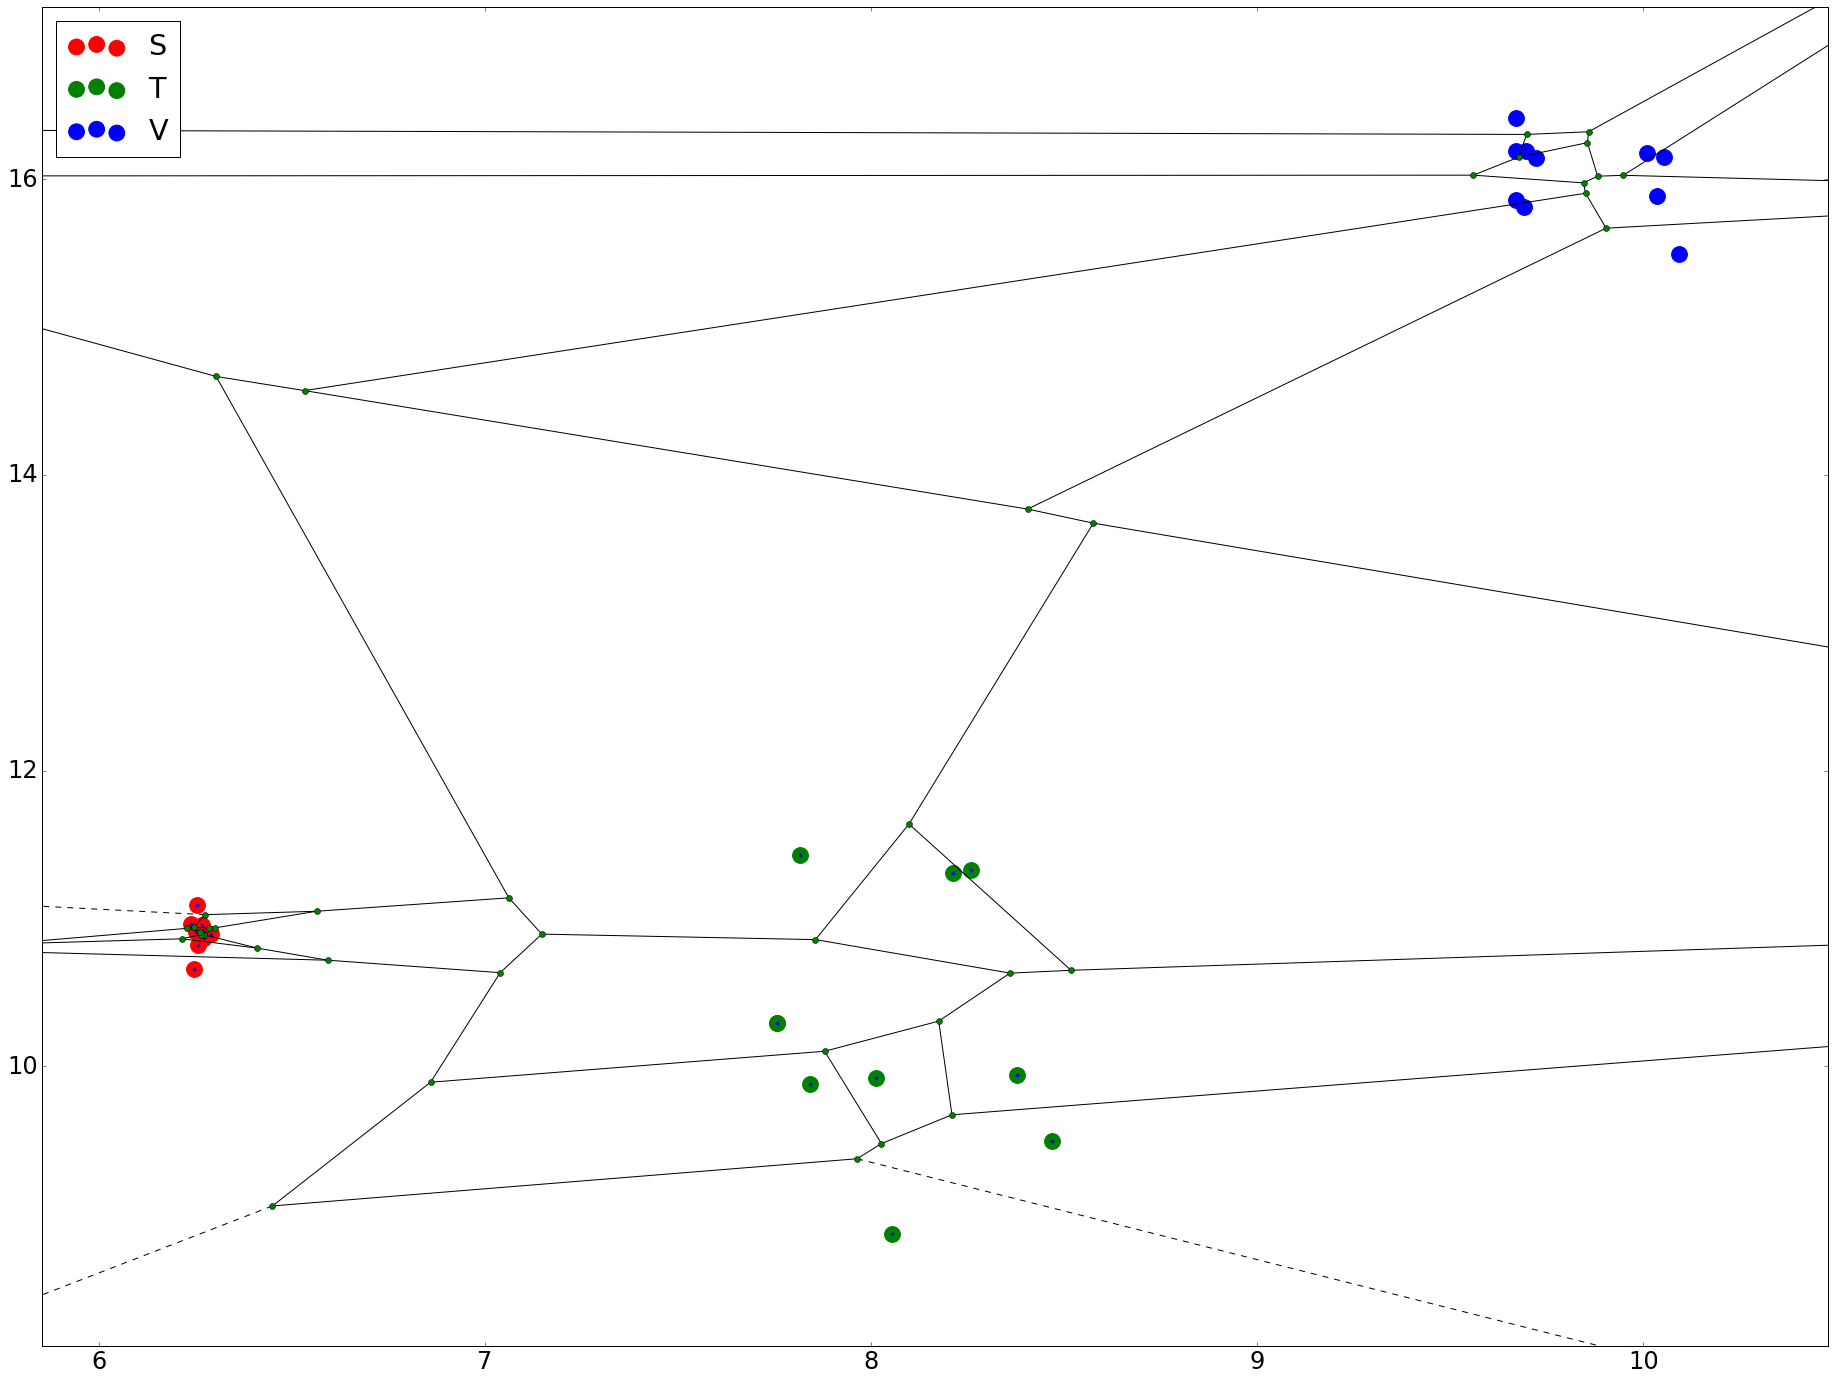

In [129]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(feature1, feature2, s=250, color="r", label="S")
ax.scatter(feature3, feature4, s=250, color="g", label="T")
ax.scatter(feature5, feature6, s=250, color="b", label="V")
ax.legend(loc=2)
forvoronoi1 = [[x[0], x[1]] for x in zip(feature1, feature2)]
forvoronoi2 = [[x[0], x[1]] for x in zip(feature3, feature4)]
forvoronoi3 = [[x[0], x[1]] for x in zip(feature5, feature6)]
points = np.array(forvoronoi1 + forvoronoi2 + forvoronoi3)
vor = Voronoi(points)
voronoi_plot_2d(vor, ax)
plt.show()

In [102]:
l1 = ["A", "B", "S", "T", "V"]
l2 = ["1", "2"]
testSamples = []
for i in range(0, len(l1)):
    for j in range(0, len(l2)):
        testSamples.append(str(l1[i]) + str(l2[j]))
        

testSamplesAll = [color.rgb2gray(io.imread("test" + s + ".png")) for s in testSamples] # test samples load
testA = testSamplesAll[:2]
testB = testSamplesAll[2:4]
testS = testSamplesAll[4:6]
testT = testSamplesAll[6:8]
testV = testSamplesAll[8:]


#cropping
croppedTestA = list(map(cropper, testA))
croppedTestB = list(map(cropper, testB))
croppedTestS = list(map(cropper, testS))
croppedTestT = list(map(cropper, testT))
croppedTestV = list(map(cropper, testV))

In [89]:
# resizing
resizedAndCroppedTestA = imageResizer(croppedTestA)
resizedAndCroppedTestB = imageResizer(croppedTestB)
resizedAndCroppedTestS = imageResizer(croppedTestS)
resizedAndCroppedTestT = imageResizer(croppedTestT)
resizedAndCroppedTestV = imageResizer(croppedTestV)

#thresholding
resizedAndCroppedTestA = list(map(thresholding, resizedAndCroppedTestA))
resizedAndCroppedTestB = list(map(thresholding, resizedAndCroppedTestB))
resizedAndCroppedTestS = list(map(thresholding, resizedAndCroppedTestS))
resizedAndCroppedTestT = list(map(thresholding, resizedAndCroppedTestT))
resizedAndCroppedTestV = list(map(thresholding, resizedAndCroppedTestV))

In [149]:
#Applying FFT and FFT shift
ker = (1/81.0)*np.ones((9,9))
testAFourier = [fftpack.fftshift(np.fft.fft2(resizedAndCroppedTestA[i])) for i in range(test_amt)]
testBFourier = [fftpack.fftshift(np.fft.fft2(resizedAndCroppedTestB[i])) for i in range(test_amt)]
testSFourier = [fftpack.fftshift(np.fft.fft2(resizedAndCroppedTestS[i])) for i in range(test_amt)]
testTFourier = [fftpack.fftshift(np.fft.fft2(resizedAndCroppedTestT[i])) for i in range(test_amt)]
testVFourier = [fftpack.fftshift(np.fft.fft2(resizedAndCroppedTestV[i])) for i in range(test_amt)]

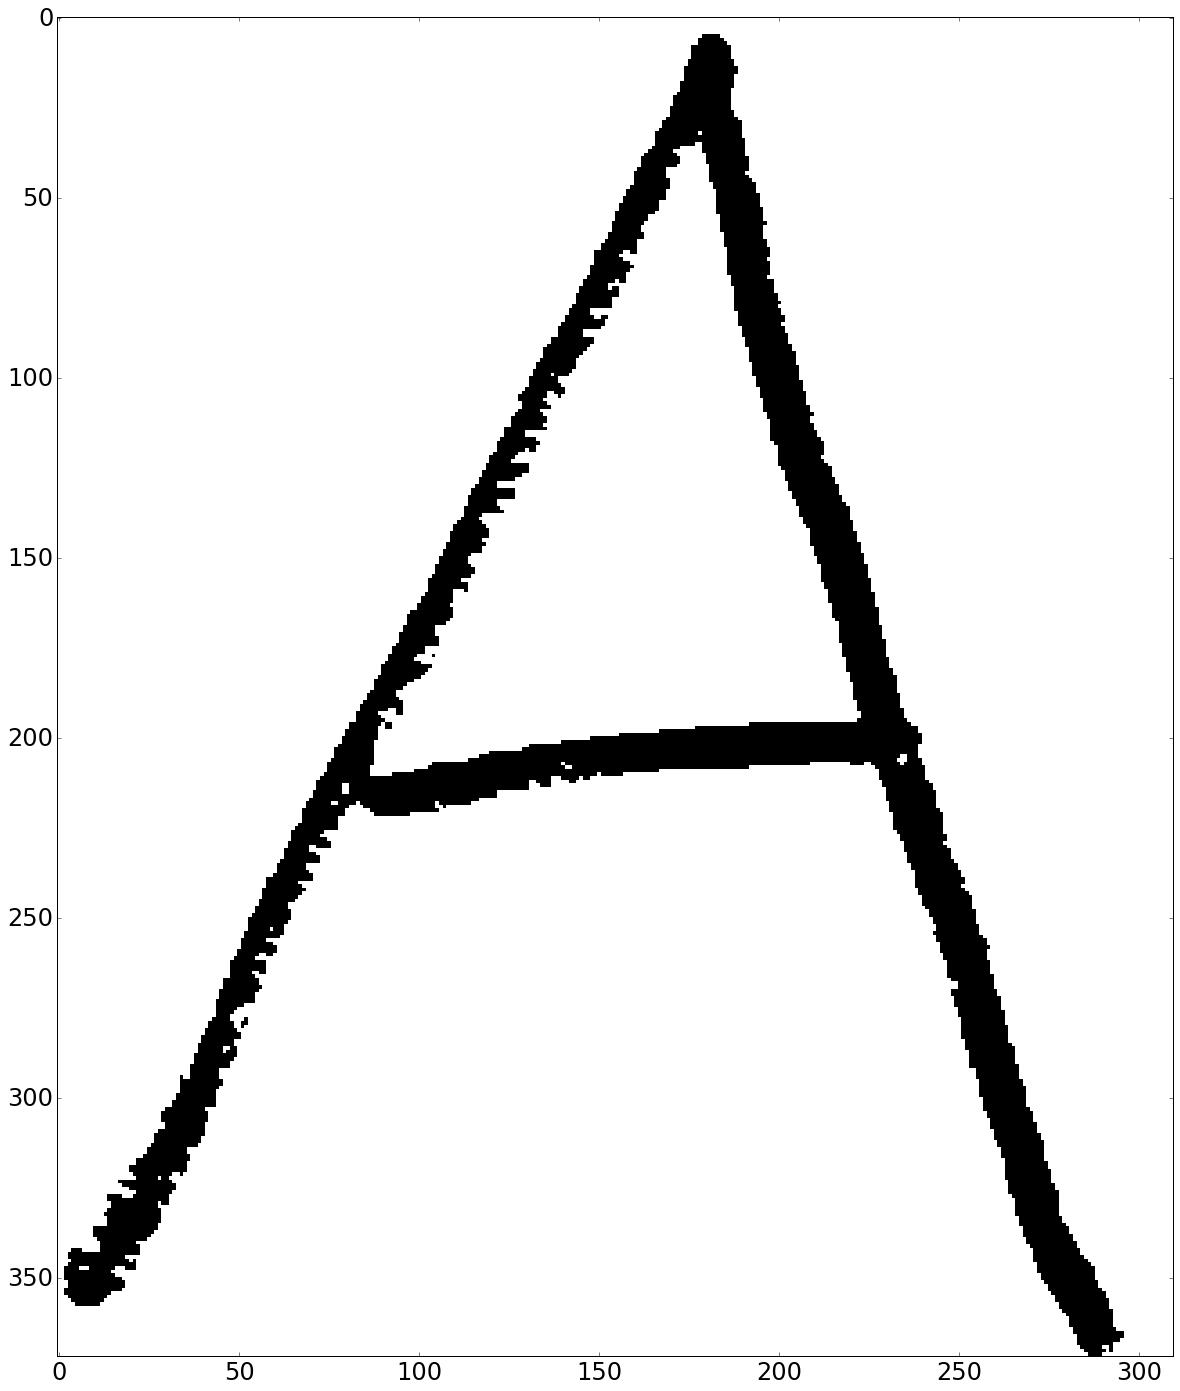

In [160]:
#ax_im = io.imshow(np.angle(fftpack.fftshift(testAFourier[0])))
#io.show()
ax_im = io.imshow(resizedAndCroppedTestA[0])
io.show()

In [155]:
#FEATURE EXTRACTION

testAfeature1 = np.array([boxpass(np.angle(testAFourier[i])) for i in range(test_amt)])
testAfeature2 = np.array([boxpass(np.log(np.abs(testAFourier[i]) + 1)) for i in range(test_amt)])
testBfeature1 = np.array([boxpass(np.angle(testBFourier[i])) for i in range(test_amt)])
testBfeature2 = np.array([boxpass(np.log(np.abs(testBFourier[i]) + 1)) for i in range(test_amt)])
testSfeature1 = np.array([boxpass(np.angle(testSFourier[i])) for i in range(test_amt)])
testSfeature2 = np.array([boxpass(np.log(np.abs(testSFourier[i]) + 1)) for i in range(test_amt)])
testTfeature1 = np.array([boxpass(np.angle(testTFourier[i])) for i in range(test_amt)])
testTfeature2 = np.array([boxpass(np.log(np.abs(testTFourier[i]) + 1)) for i in range(test_amt)])
testVfeature1 = np.array([boxpass(np.angle(testVFourier[i])) for i in range(test_amt)])
testVfeature2 = np.array([boxpass(np.log(np.abs(testVFourier[i]) + 1)) for i in range(test_amt)])
"""
ker = (1/81.0)*np.ones((9,9))
testAfeature1 = np.array([ndimage.convolve((np.angle(testAFourier[i])), ker) for i in range(test_amt)])
testAfeature2 = np.array([ndimage.convolve((np.log(np.abs(testAFourier[i]) + 1)), ker) for i in range(test_amt)])
testBfeature1 = np.array([ndimage.convolve((np.angle(testBFourier[i])), ker) for i in range(test_amt)])
testBfeature2 = np.array([ndimage.convolve((np.log(np.abs(testBFourier[i]) + 1)), ker) for i in range(test_amt)])
testSfeature1 = np.array([ndimage.convolve((np.angle(testSFourier[i])), ker) for i in range(test_amt)])
testSfeature2 = np.array([ndimage.convolve((np.log(np.abs(testSFourier[i]) + 1)), ker) for i in range(test_amt)])
testTfeature1 = np.array([ndimage.convolve((np.angle(testTFourier[i])), ker) for i in range(test_amt)])
testTfeature2 = np.array([ndimage.convolve((np.log(np.abs(testTFourier[i]) + 1)), ker) for i in range(test_amt)])
testVfeature1 = np.array([ndimage.convolve((np.angle(testVFourier[i])), ker) for i in range(test_amt)])
testVfeature2 = np.array([ndimage.convolve((np.log(np.abs(testVFourier[i]) + 1)), ker) for i in range(test_amt)])
"""

'\nker = (1/81.0)*np.ones((9,9))\ntestAfeature1 = np.array([ndimage.convolve((np.angle(testAFourier[i])), ker) for i in range(test_amt)])\ntestAfeature2 = np.array([ndimage.convolve((np.log(np.abs(testAFourier[i]) + 1)), ker) for i in range(test_amt)])\ntestBfeature1 = np.array([ndimage.convolve((np.angle(testBFourier[i])), ker) for i in range(test_amt)])\ntestBfeature2 = np.array([ndimage.convolve((np.log(np.abs(testBFourier[i]) + 1)), ker) for i in range(test_amt)])\ntestSfeature1 = np.array([ndimage.convolve((np.angle(testSFourier[i])), ker) for i in range(test_amt)])\ntestSfeature2 = np.array([ndimage.convolve((np.log(np.abs(testSFourier[i]) + 1)), ker) for i in range(test_amt)])\ntestTfeature1 = np.array([ndimage.convolve((np.angle(testTFourier[i])), ker) for i in range(test_amt)])\ntestTfeature2 = np.array([ndimage.convolve((np.log(np.abs(testTFourier[i]) + 1)), ker) for i in range(test_amt)])\ntestVfeature1 = np.array([ndimage.convolve((np.angle(testVFourier[i])), ker) for i in 

[[ 6.25997265  6.2504658   6.25696736  6.27191565  6.23770389  6.27077737
   6.24553042  6.29044301  6.26579365  6.25484292  7.81594865  7.75636179
   8.05491688  8.46822877  8.37747508  7.75636179  8.01340472  8.21222296
   8.25756082  7.84124307 10.00905466  9.69019763 10.03515861 10.05287386
  10.09173417  9.66997551  9.67108366  9.69600787  9.66954161  9.72153167]
 [10.92145575 10.90785632 10.82328723 10.86974928 10.96582368 10.91038791
  10.66001634 10.89807356 10.95581409 11.09348702 11.42919701 10.29228688
   8.86490845  9.49271905  9.93905212 10.29228688  9.91933314 11.30633026
  11.32557604  9.87876865 16.17640678 15.81054433 15.88830169 16.14993818
  15.49384009 15.86082758 16.41190064 16.18928114 16.19285547 16.14283213]]


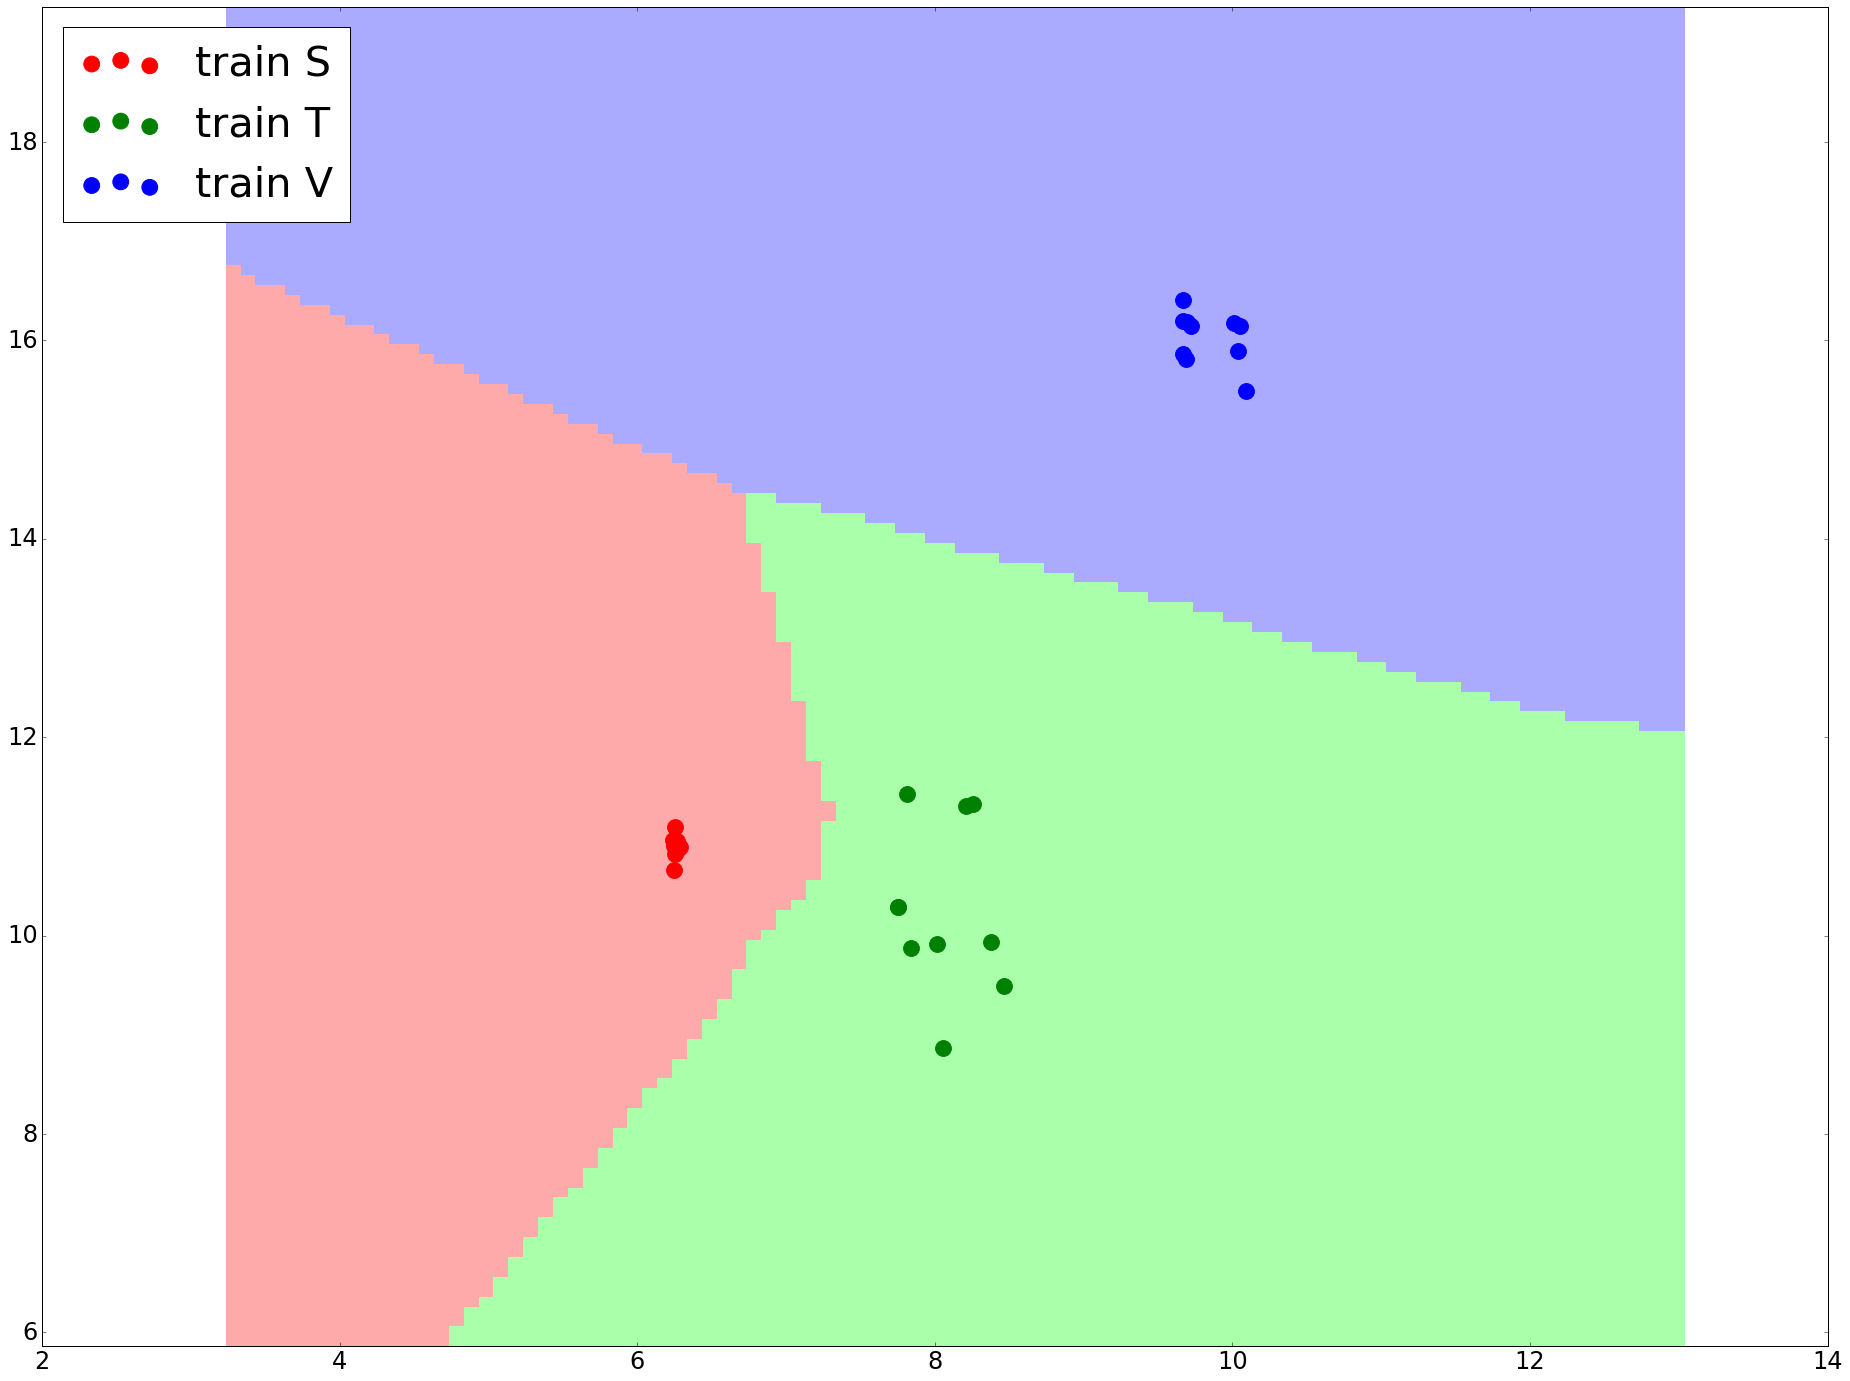

In [140]:
xvalues = np.concatenate((feature1, feature3, feature5), axis=0)
yvalues = np.concatenate((feature2, feature4, feature6), axis=0)
dataToFit = np.vstack((xvalues, yvalues))
dataInTuples = list(zip(xvalues, yvalues))
print(dataToFit)

classes = [0,0,0,0,0,0,0,0,0,0, 1,1,1,1,1,1,1,1,1,1, 2,2,2,2,2,2,2,2,2,2]

neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(dataInTuples, classes)

fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
x_min, x_max = xvalues.min() - 3, xvalues.max() + 3
y_min, y_max = yvalues.min() - 3, yvalues.max() + 3
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
Z1 = neigh.predict(np.c_[xx.ravel(), yy.ravel()])

cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])


# Put the result into a color plot
Z1 = Z1.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z1, cmap=cmap_light)

# Plot also the training points
ax2.scatter(feature1, feature2, s=250, color="r", label="train S")
ax2.scatter(feature3, feature4, s=250, color="g", label="train T")
ax2.scatter(feature5, feature6, s=250, color="b", label="train V")

#ax2.scatter(testSfeature1, testSfeature2, marker="^", s=500, color="r", label="test S")
#ax2.scatter(testTfeature1, testTfeature2, marker="^", s=500, color="g", label="test T")
#ax2.scatter(testVfeature1, testVfeature2,  marker="^", s=500, color="b", label="test V")

plt.ylim(yy.min(), yy.max())
ax2.legend(loc=2,fontsize = 'xx-large')
plt.show()

In [ ]:
#WITHOUT CROPPING RESULTS
trainSFourierNoCrop = [fftpack.fftshift(np.fft.fft2(trainS[i])) for i in range(train_amt)]
trainTFourierNoCrop = [fftpack.fftshift(np.fft.fft2(trainT[i])) for i in range(train_amt)]
trainVFourierNoCrop = [fftpack.fftshift(np.fft.fft2(trainV[i])) for i in range(train_amt)]

feature1NoCrop = np.array([boxpass(np.angle(trainTFourierNoCrop[i])) for i in range(train_amt)])
feature2NoCrop = np.array([boxpass(np.log(np.abs(trainTFourierNoCrop[i]) + 1)) for i in range(train_amt)])
feature3NoCrop = np.array([boxpass(np.angle(trainSFourierNoCrop[i])) for i in range(train_amt)])
feature4NoCrop = np.array([boxpass(np.log(np.abs(trainSFourierNoCrop[i]) + 1)) for i in range(train_amt)])
feature5NoCrop = np.array([boxpass(np.angle(trainVFourierNoCrop[i])) for i in range(train_amt)])
feature6NoCrop = np.array([boxpass(np.log(np.abs(trainVFourierNoCrop[i]) + 1)) for i in range(train_amt)])

xvaluesNoCrop = np.concatenate((feature1NoCrop, feature3NoCrop, feature5NoCrop), axis=0)
yvaluesNoCrop = np.concatenate((feature2NoCrop, feature4NoCrop, feature6NoCrop), axis=0)
dataToFitNoCrop = np.vstack((xvaluesNoCrop, yvaluesNoCrop))
dataInTuplesNoCrop = list(zip(xvaluesNoCrop, yvaluesNoCrop))
print(dataToFitNoCrop)

classes = [0,0,0,0,0,0,0,0,0,0, 1,1,1,1,1,1,1,1,1,1, 2,2,2,2,2,2,2,2,2,2]

neighNoCrop = KNeighborsClassifier(n_neighbors=5)
neighNoCrop.fit(dataInTuplesNoCrop, classes)

fig2NoCrop = plt.figure()
ax2NoCrop = fig2NoCrop.add_subplot(111)
x_minNoCrop, x_maxNoCrop = xvaluesNoCrop.min() - 3, xvaluesNoCrop.max() + 3
y_minNoCrop, y_maxNoCrop = yvaluesNoCrop.min() - 3, yvaluesNoCrop.max() + 3
xxNoCrop, yyNoCrop = np.meshgrid(np.arange(x_minNoCrop, x_maxNoCrop, 0.1), np.arange(y_minNoCrop, y_maxNoCrop, 0.1))
Z1NoCrop = neighNoCrop.predict(np.c_[xxNoCrop.ravel(), yyNoCrop.ravel()])

# Put the result into a color plot
Z1NoCrop = Z1NoCrop.reshape(xxNoCrop.shape)
plt.pcolormesh(xxNoCrop, yyNoCrop, Z1NoCrop, cmap=cmap_light)

# Plot also the training points
ax2NoCrop.scatter(feature1NoCrop, feature2NoCrop, s=250, color="r", label="T")
ax2NoCrop.scatter(feature3NoCrop, feature4NoCrop, s=250, color="g", label="S")
ax2NoCrop.scatter(feature5NoCrop, feature6NoCrop, s=250, color="b", label="V")
plt.ylim(yyNoCrop.min(), yyNoCrop.max())
ax2NoCrop.legend(loc=2,fontsize = 'xx-large')
plt.show()

[[ 6.25997265  6.2504658   6.25696736  6.27191565  6.23770389  6.27077737
   6.24553042  6.29044301  6.26579365  6.25484292  7.81594865  7.75636179
   8.05491688  8.46822877  8.37747508  7.75636179  8.01340472  8.21222296
   8.25756082  7.84124307 10.00905466  9.69019763 10.03515861 10.05287386
  10.09173417  9.66997551  9.67108366  9.69600787  9.66954161  9.72153167]
 [10.92145575 10.90785632 10.82328723 10.86974928 10.96582368 10.91038791
  10.66001634 10.89807356 10.95581409 11.09348702 11.42919701 10.29228688
   8.86490845  9.49271905  9.93905212 10.29228688  9.91933314 11.30633026
  11.32557604  9.87876865 16.17640678 15.81054433 15.88830169 16.14993818
  15.49384009 15.86082758 16.41190064 16.18928114 16.19285547 16.14283213]]
[8.17900749]
[42.02048196]


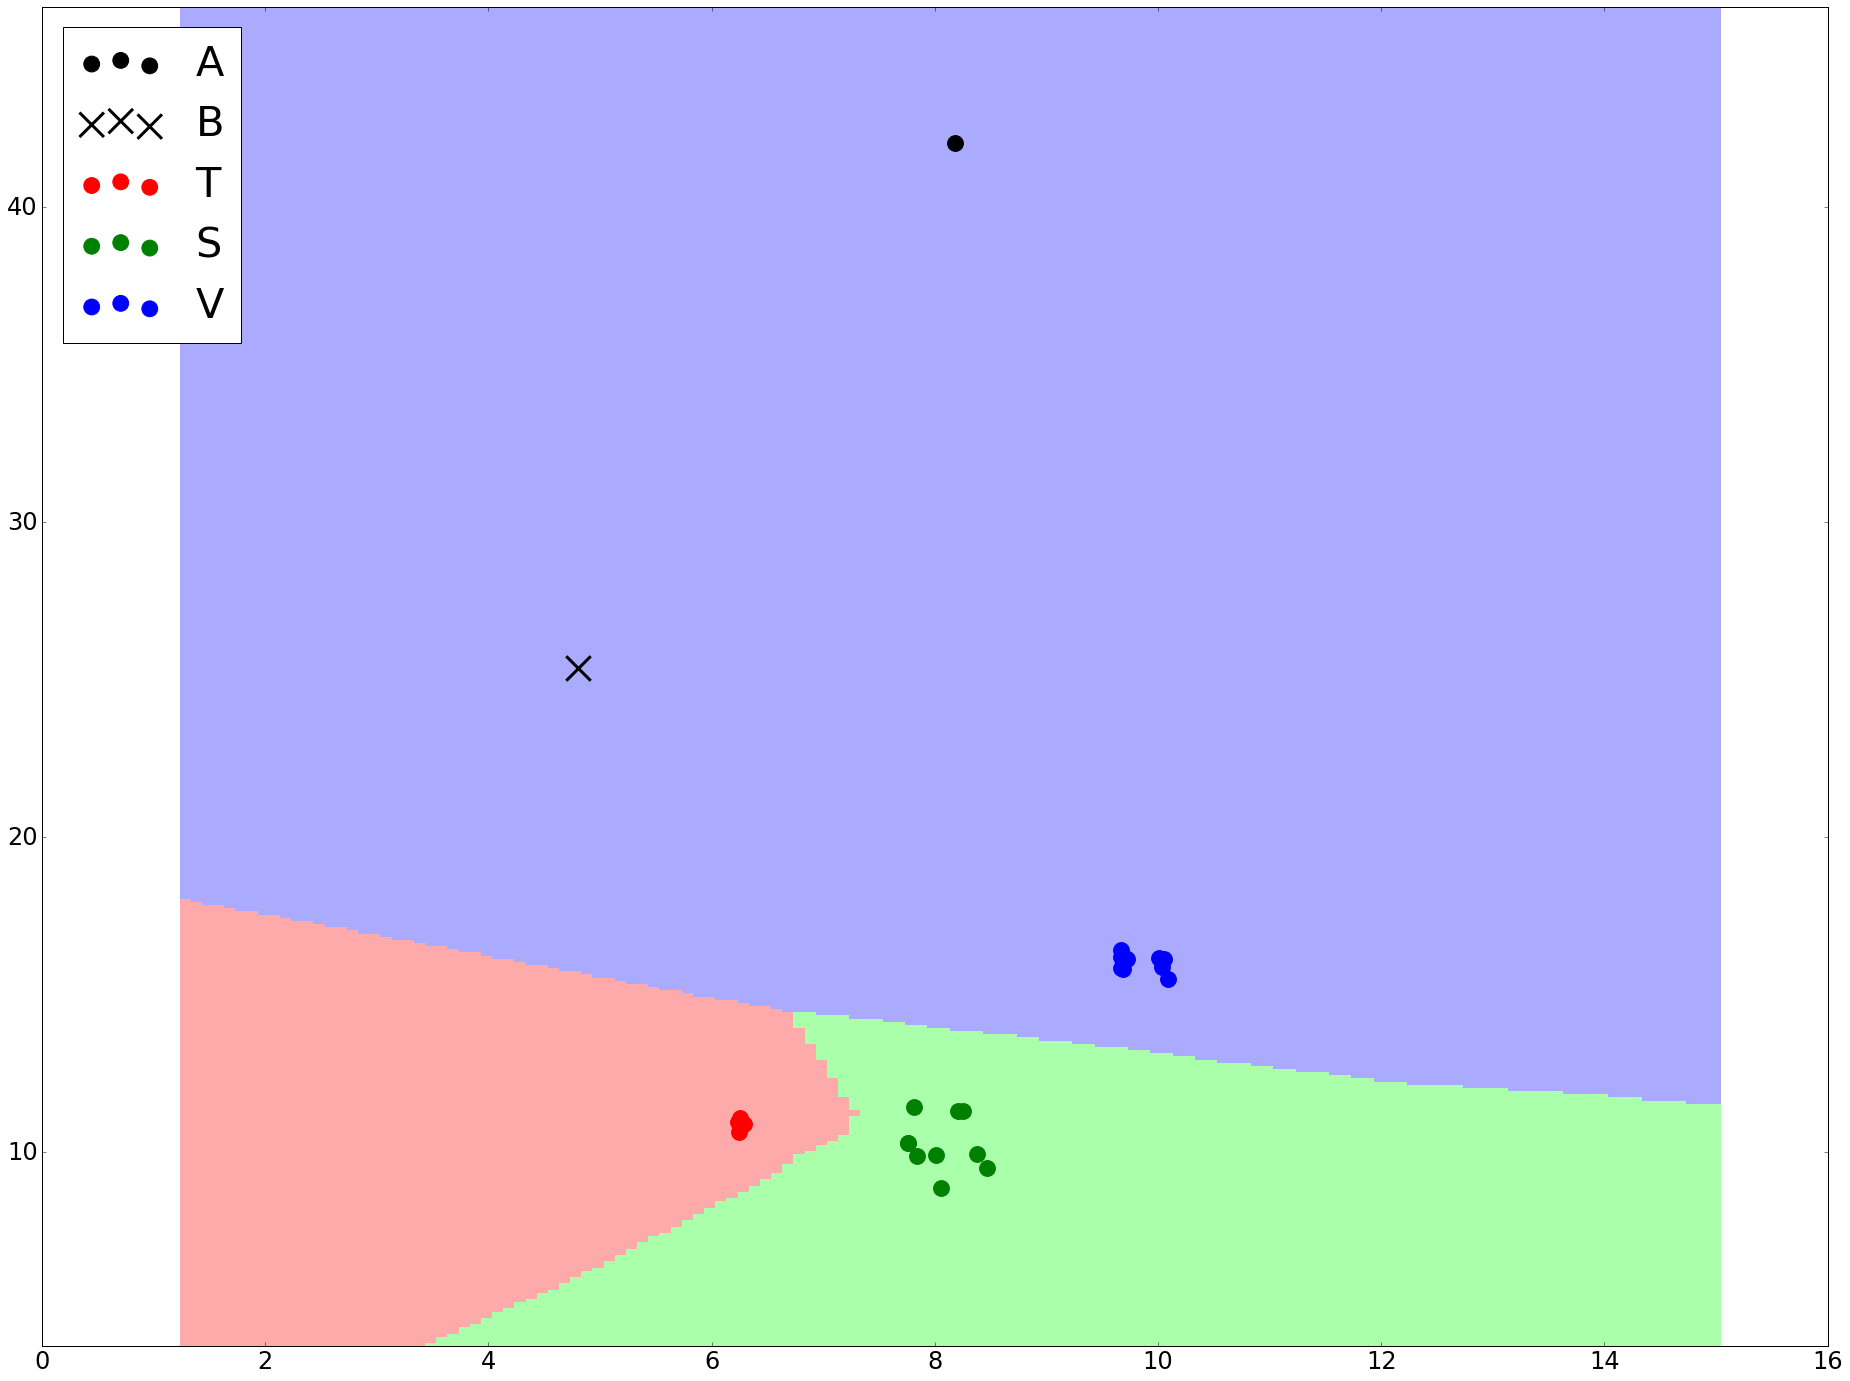

In [145]:
xvalues = np.concatenate((feature1, feature3, feature5), axis=0)
yvalues = np.concatenate((feature2, feature4, feature6), axis=0)
dataToFit = np.vstack((xvalues, yvalues))
dataInTuples = list(zip(xvalues, yvalues))
print(dataToFit)

classes = [0,0,0,0,0,0,0,0,0,0, 1,1,1,1,1,1,1,1,1,1, 2,2,2,2,2,2,2,2,2,2]

neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(dataInTuples, classes)

fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
x_min, x_max = xvalues.min() - 5, xvalues.max() + 5
y_min, y_max = yvalues.min() - 5, yvalues.max() + 30
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
Z1 = neigh.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z1 = Z1.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z1, cmap=cmap_light)

#bring A and B
testA = [color.rgb2gray(io.imread("A1.GIF"))]
testB = [color.rgb2gray(io.imread("B1.GIF"))]
#crop them
testACropped = list(map(cropper, testA))
testBCropped = list(map(cropper, testB))
#no resize needed since only one sample for A and B
# apply fourier transform
testAFourier = [fftpack.fftshift(np.fft.fft2(testACropped[0]))]
testBFourier = [fftpack.fftshift(np.fft.fft2(testBCropped[0]))]
#apply filter
Afeature1 = np.array([boxpass(np.angle(testAFourier[0]))])
Afeature2 = np.array([boxpass(np.log(np.abs(testAFourier[0]) + 1))])
Bfeature1 = np.array([boxpass(np.angle(testBFourier[0]))])
Bfeature2 = np.array([boxpass(np.log(np.abs(testBFourier[0]) + 1))])

ax2.scatter(Afeature1, Afeature2, s=250, color="k", label="A")
ax2.scatter(Bfeature1, Bfeature2, marker="x", s=600, color="k", label="B", linewidths=3)
print(Afeature1)
print(Afeature2)


# Plot also the training points
ax2.scatter(feature1, feature2, s=250, color="r", label="T")
ax2.scatter(feature3, feature4, s=250, color="g", label="S")
ax2.scatter(feature5, feature6, s=250, color="b", label="V")
plt.ylim(yy.min(), yy.max())
ax2.legend(loc=2,fontsize = 'xx-large')



plt.show()

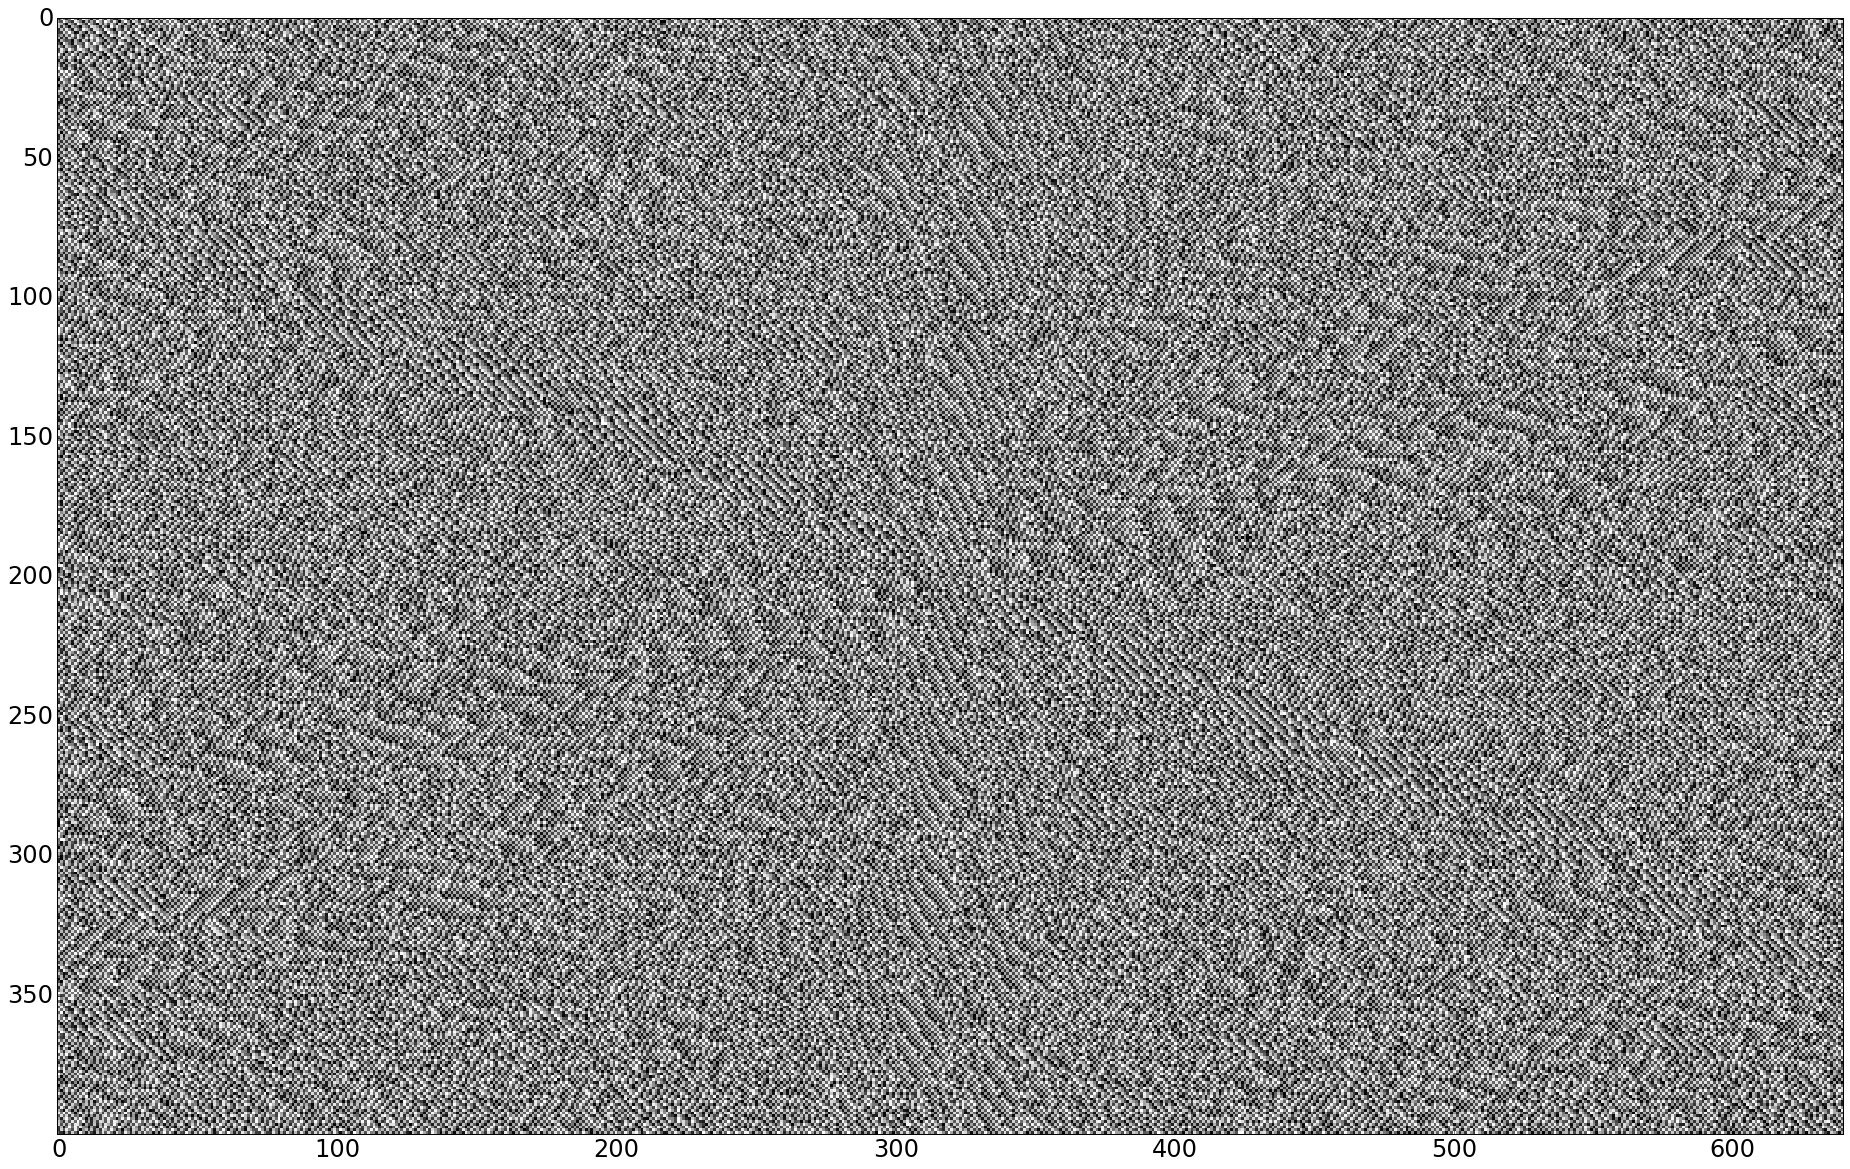

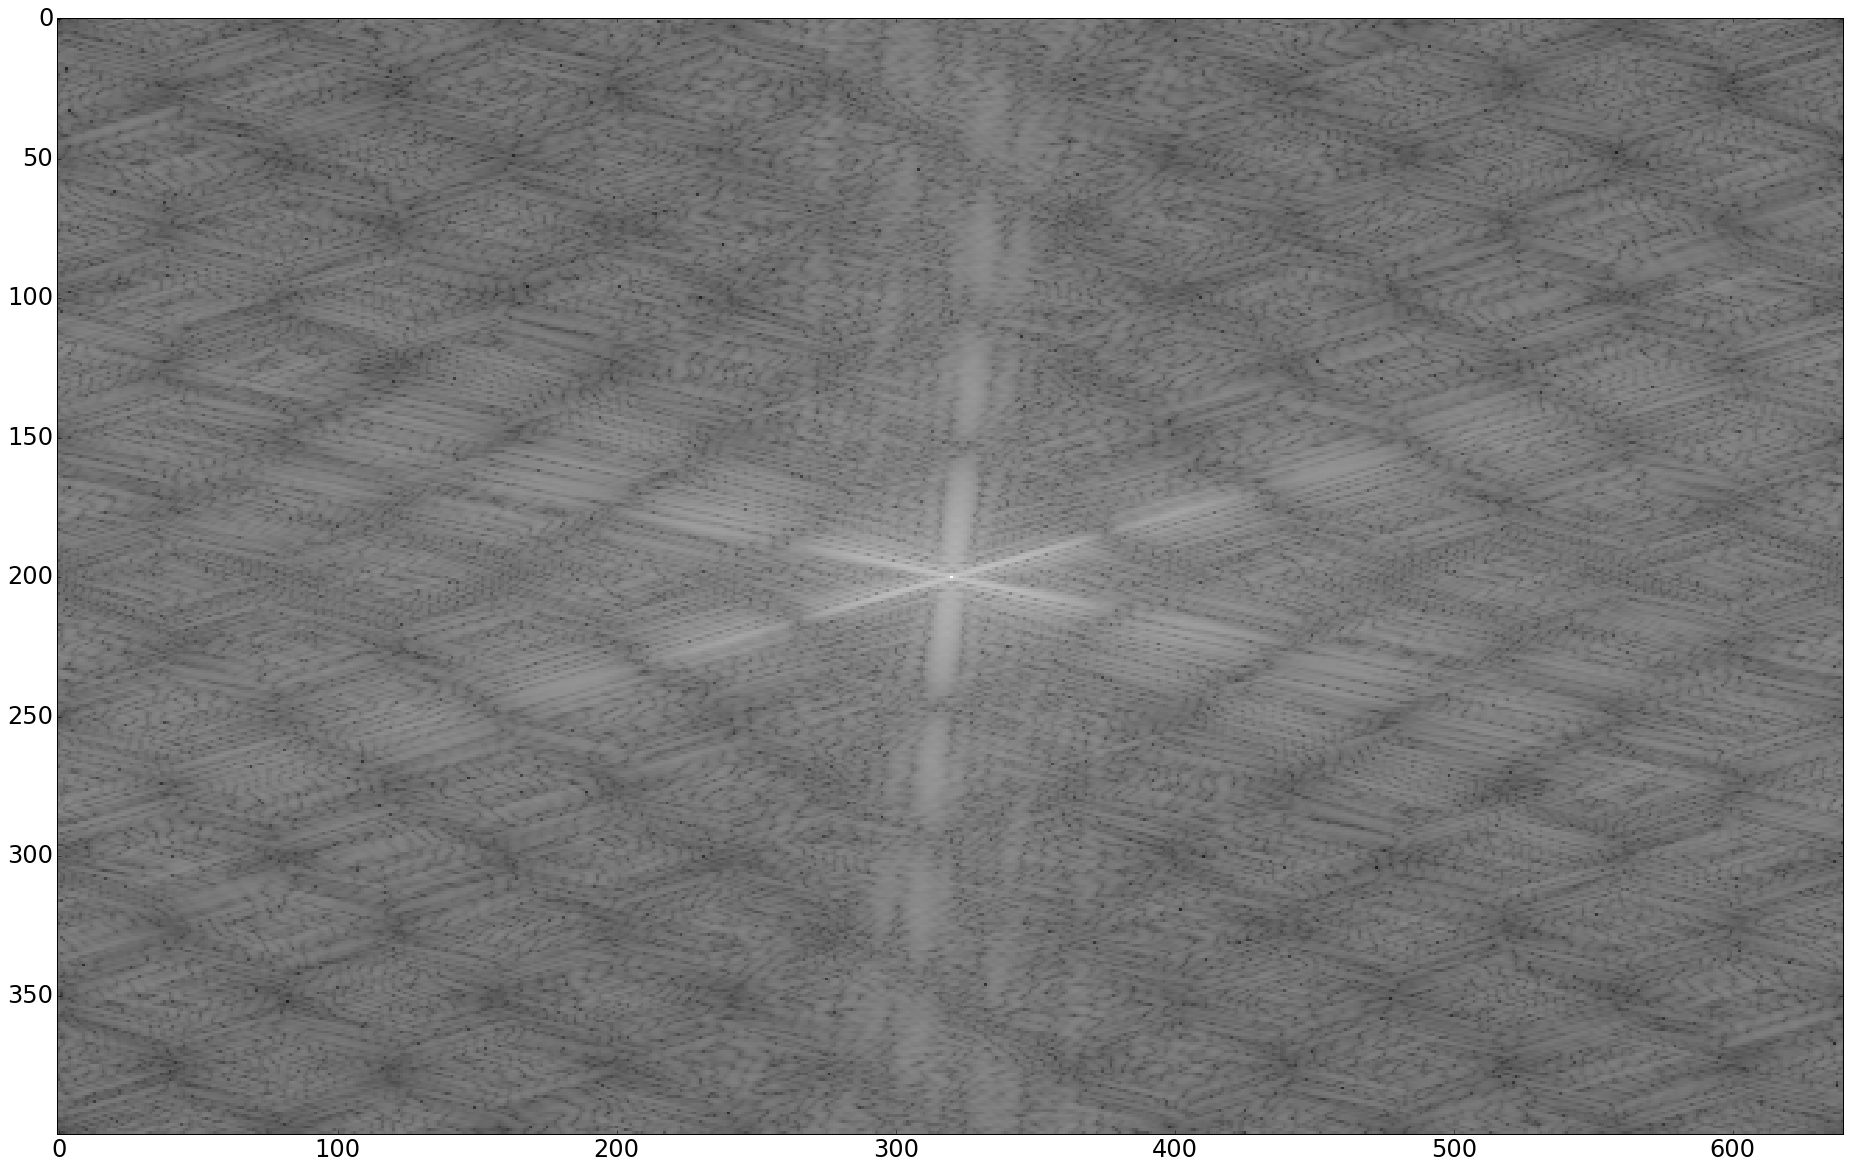

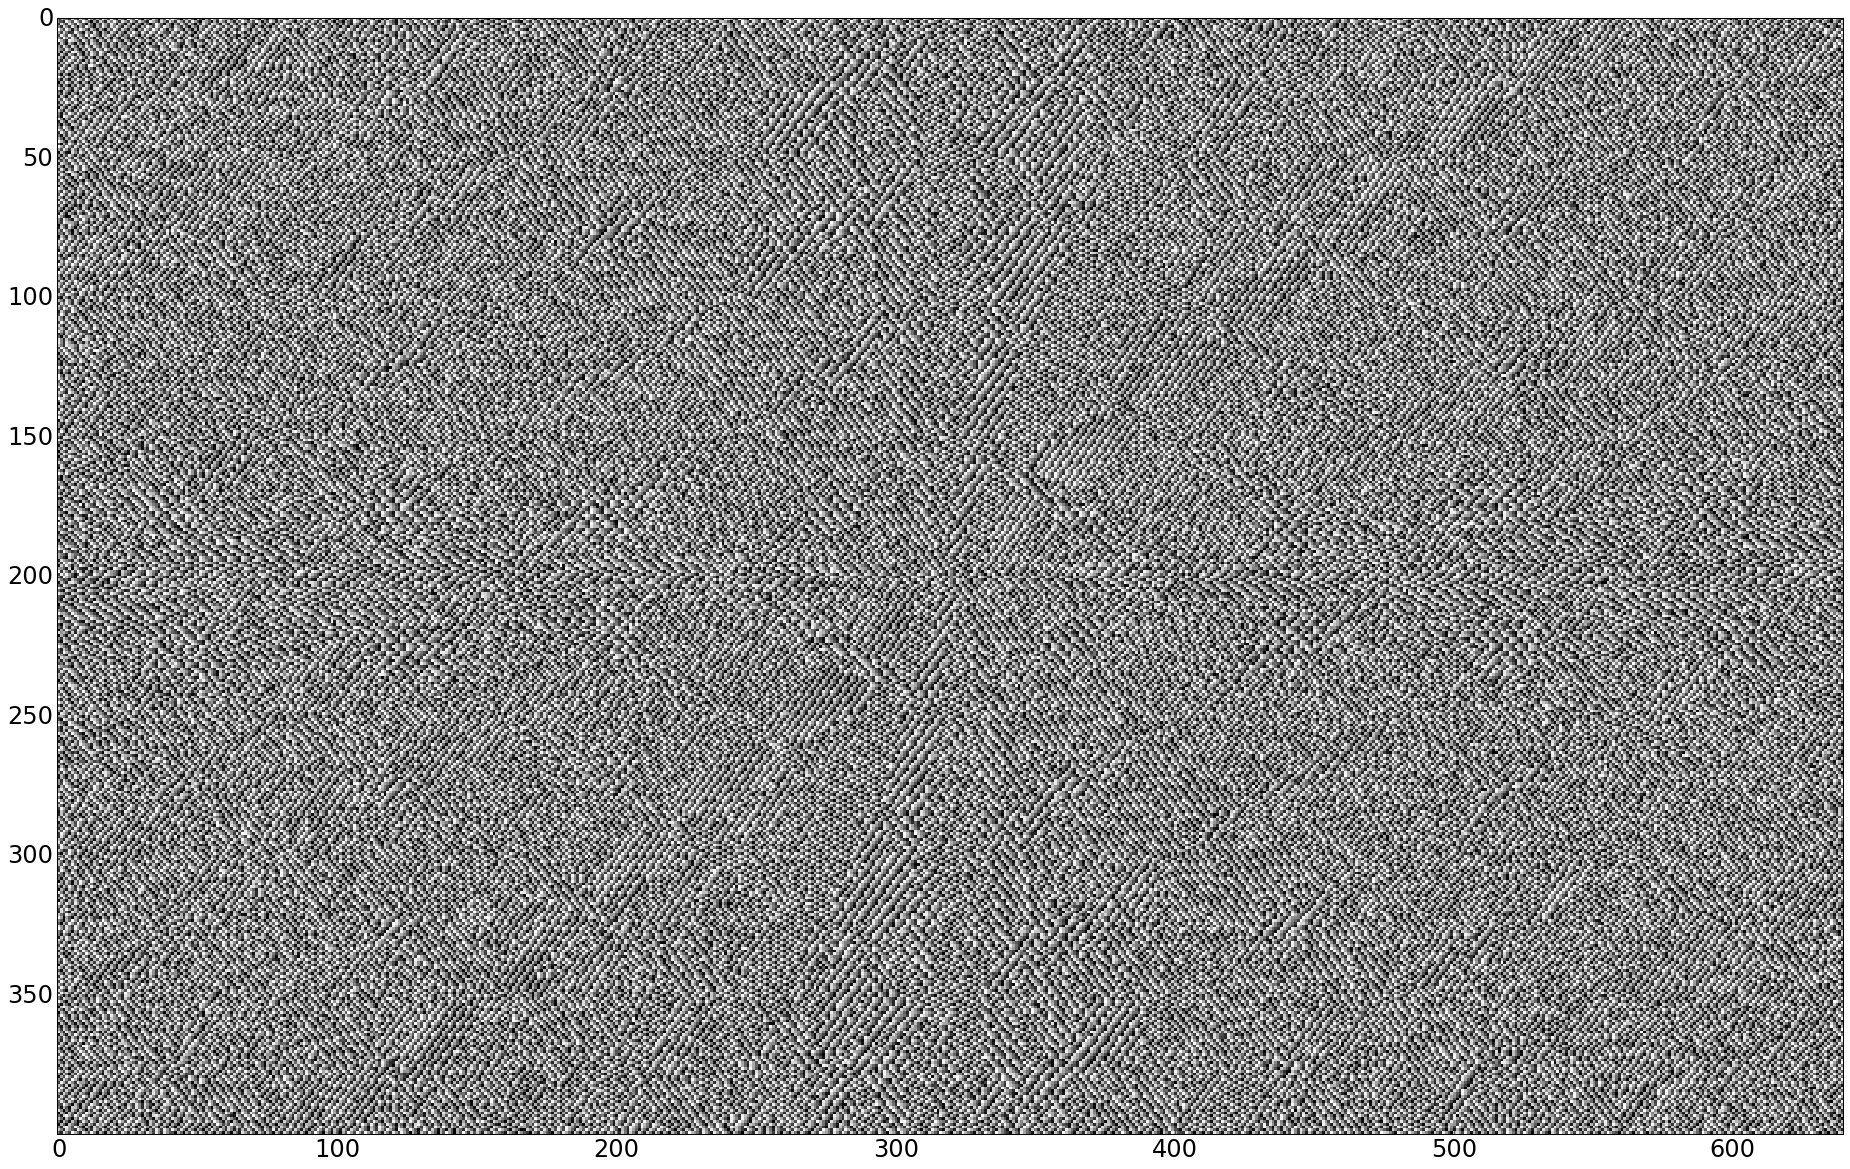

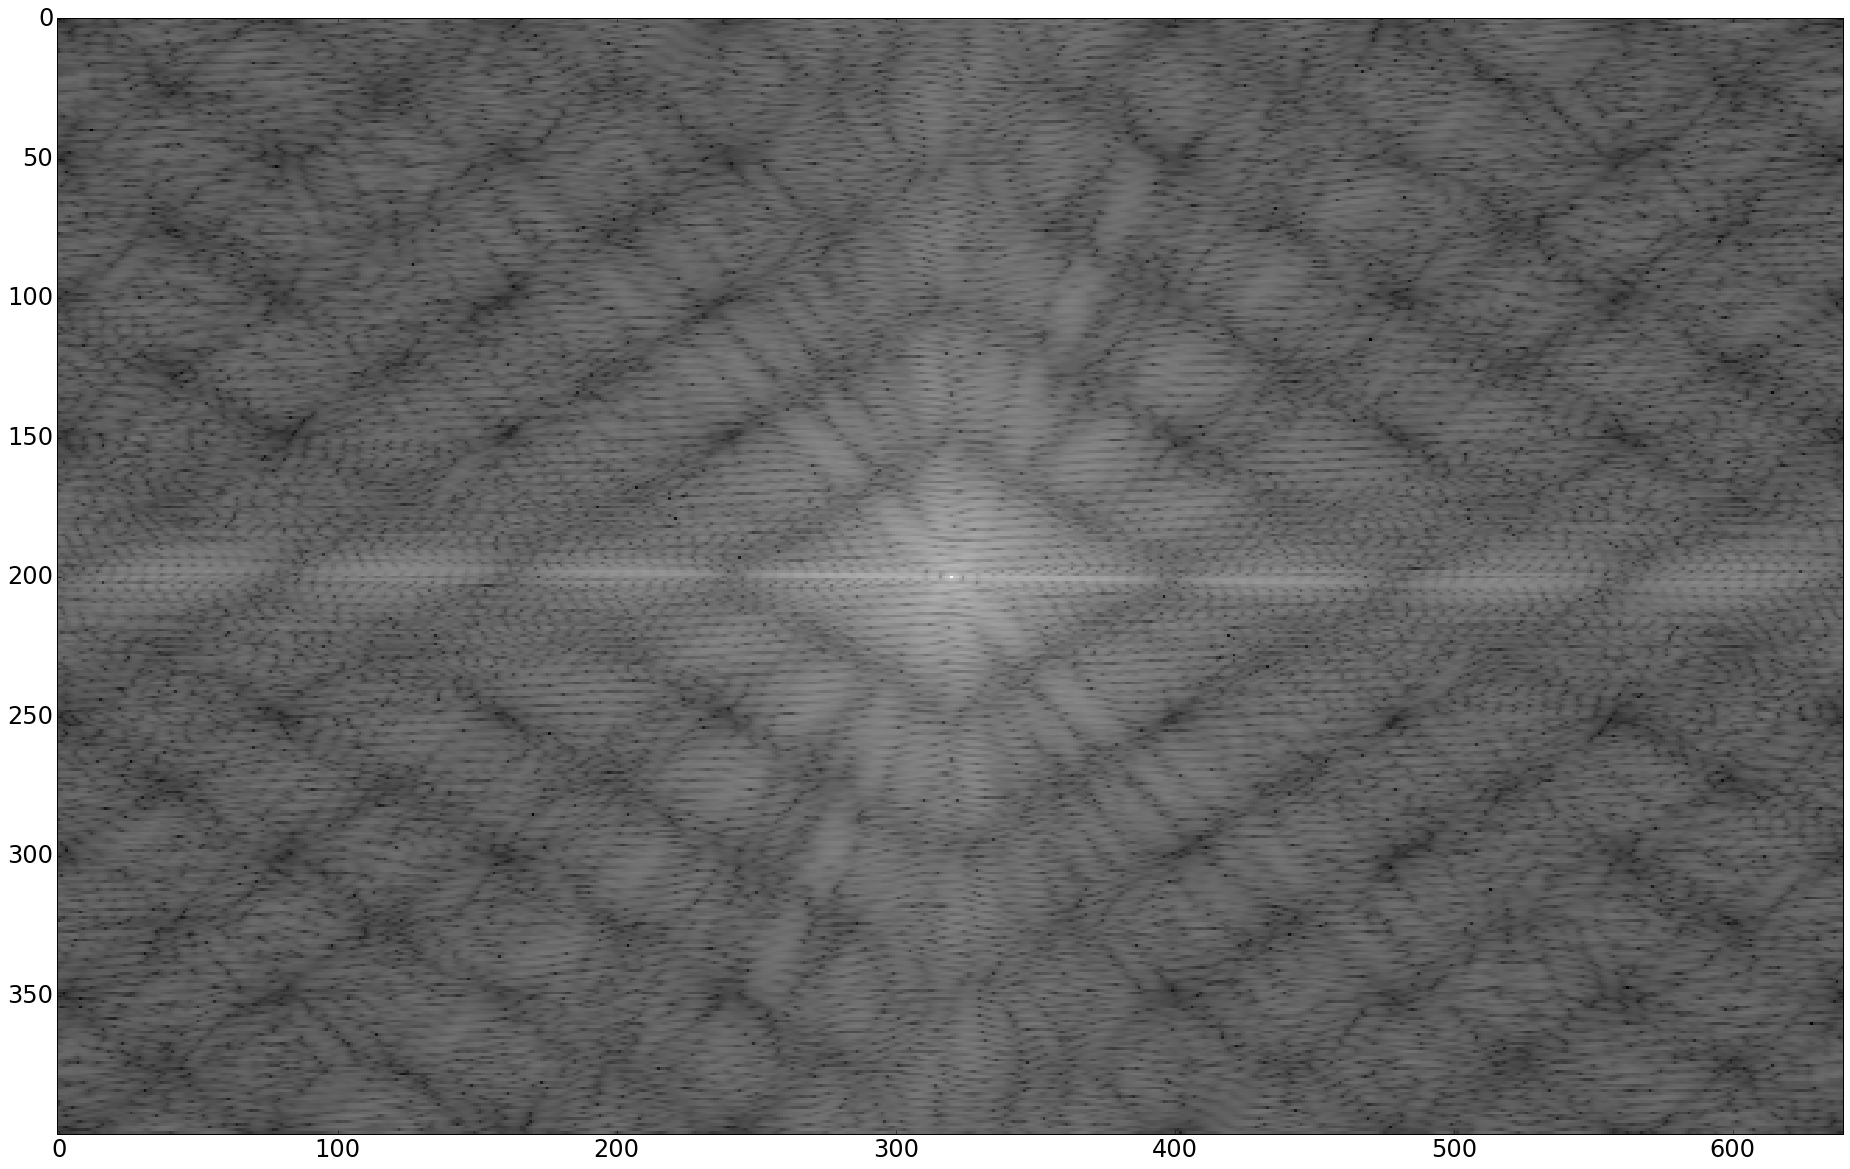

In [60]:
testA = [color.rgb2gray(io.imread("A1.GIF"))]
testB = [color.rgb2gray(io.imread("B1.GIF"))]

AFourierNoCrop = [fftpack.fft2(testA[0])]
BFourierNoCrop = [fftpack.fft2(testB[0])]

ax_im = io.imshow(np.angle(fftpack.fftshift(AFourierNoCrop[0])))
io.show()
ax_im = io.imshow(np.log(fftpack.fftshift(np.abs(AFourierNoCrop[0] + 1))))
io.show()
ax_im = io.imshow(np.angle(fftpack.fftshift(BFourierNoCrop[0])))
io.show()
ax_im = io.imshow(np.log(fftpack.fftshift(np.abs(BFourierNoCrop[0] + 1))))
io.show()

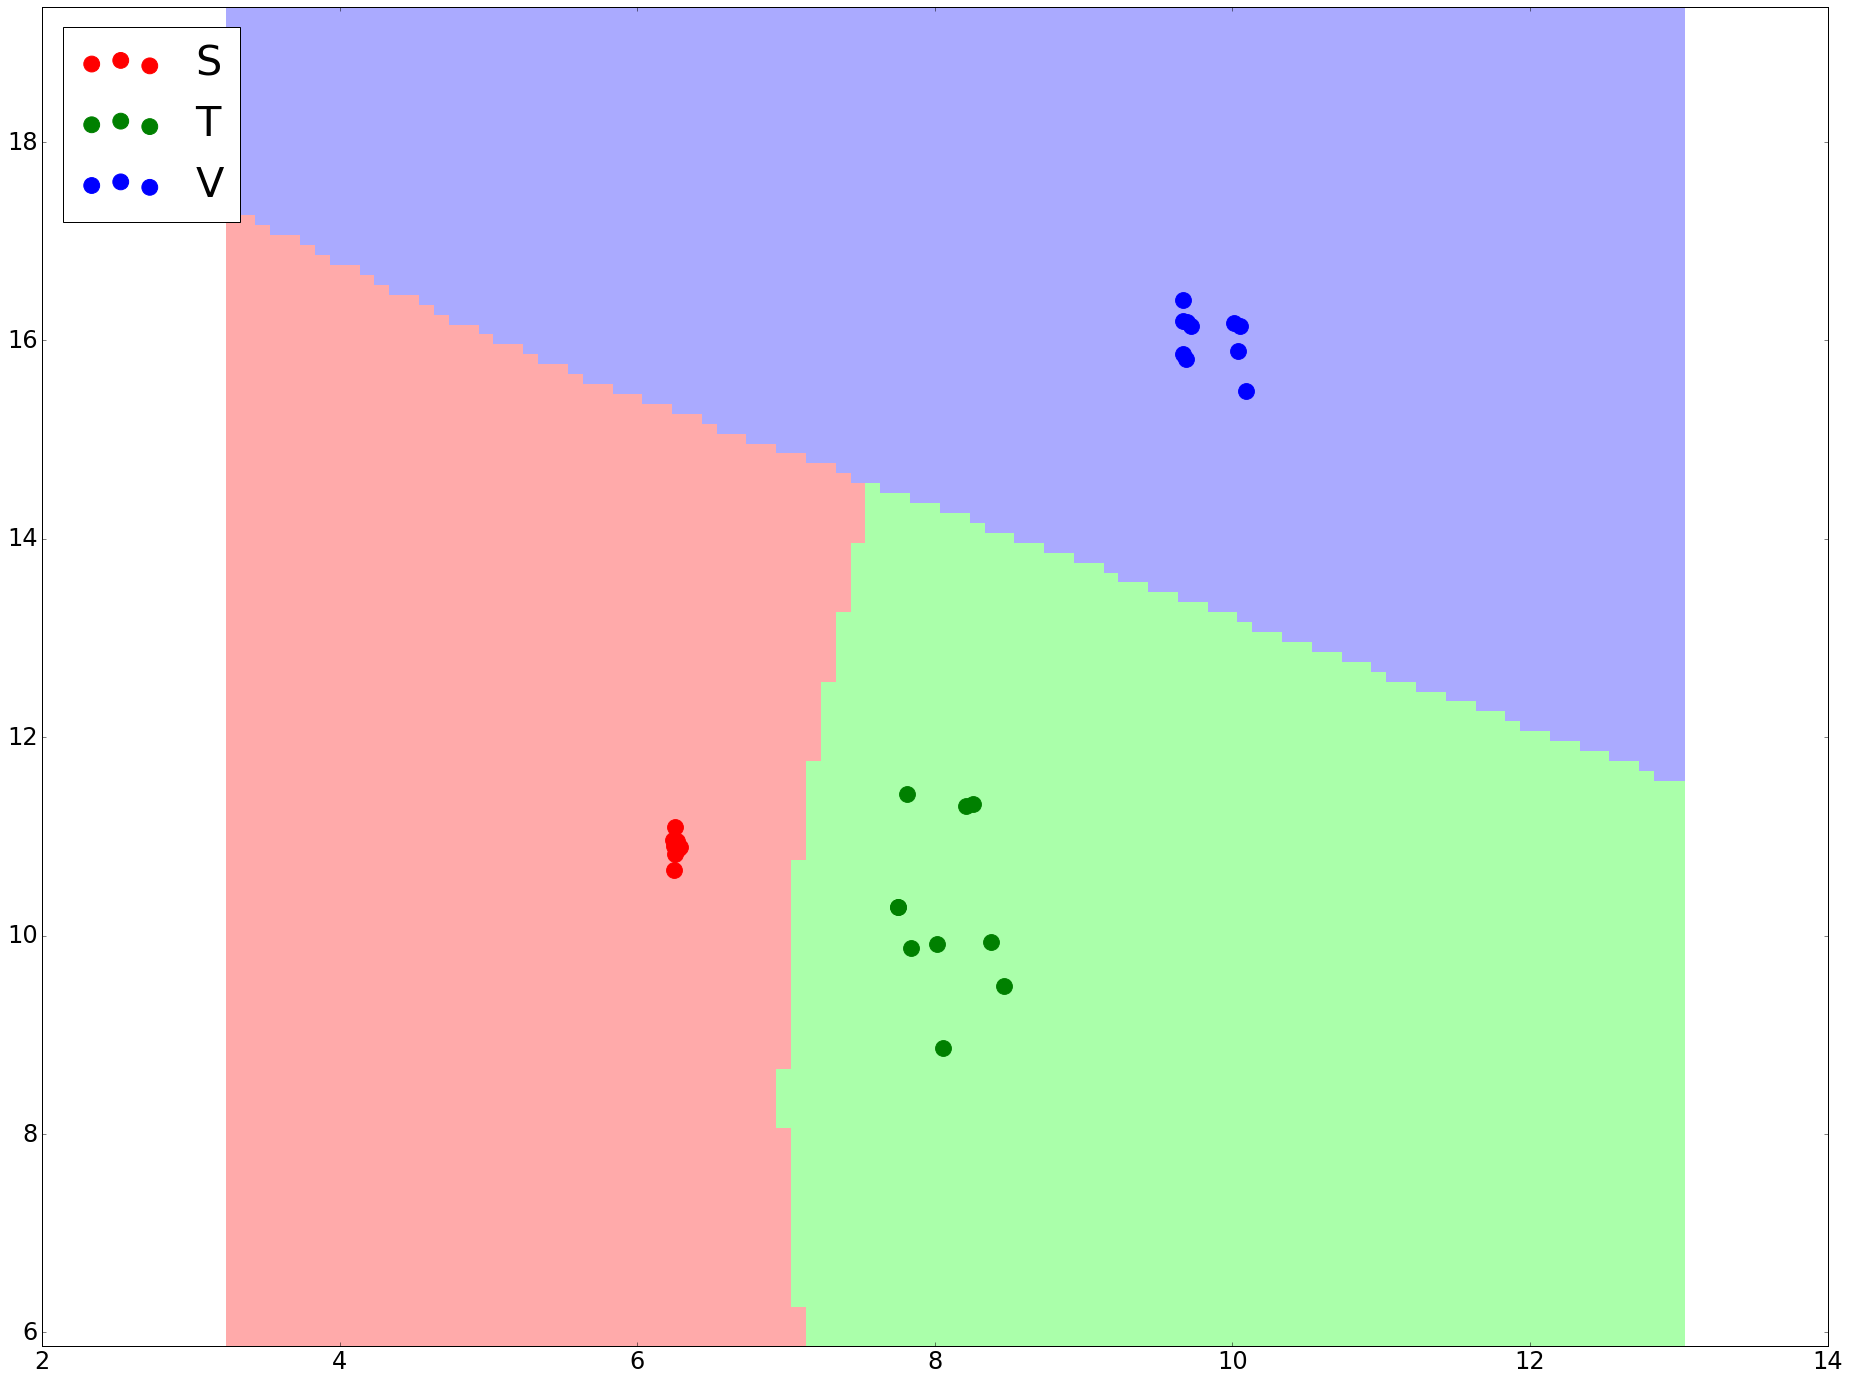

In [125]:
# Support Vector Machine

neighSVM = svm.SVC(kernel="poly", degree=2)
neighSVM.fit(dataInTuples, classes)

fig3 = plt.figure()
ax3 = fig3.add_subplot(111)
x_min, x_max = xvalues.min() - 3, xvalues.max() + 3
y_min, y_max = yvalues.min() - 3, yvalues.max() + 3
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
ZSVM = neighSVM.predict(np.c_[xx.ravel(), yy.ravel()])

cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])


# Put the result into a color plot
ZSVM = ZSVM.reshape(xx.shape)
plt.pcolormesh(xx, yy, ZSVM, cmap=cmap_light)

# Plot also the training points
ax3.scatter(feature1, feature2, s=250, color="r", label="S")
ax3.scatter(feature3, feature4, s=250, color="g", label="T")
ax3.scatter(feature5, feature6, s=250, color="b", label="V")
plt.ylim(yy.min(), yy.max())
ax3.legend(loc=2,fontsize = 'xx-large')
plt.show()

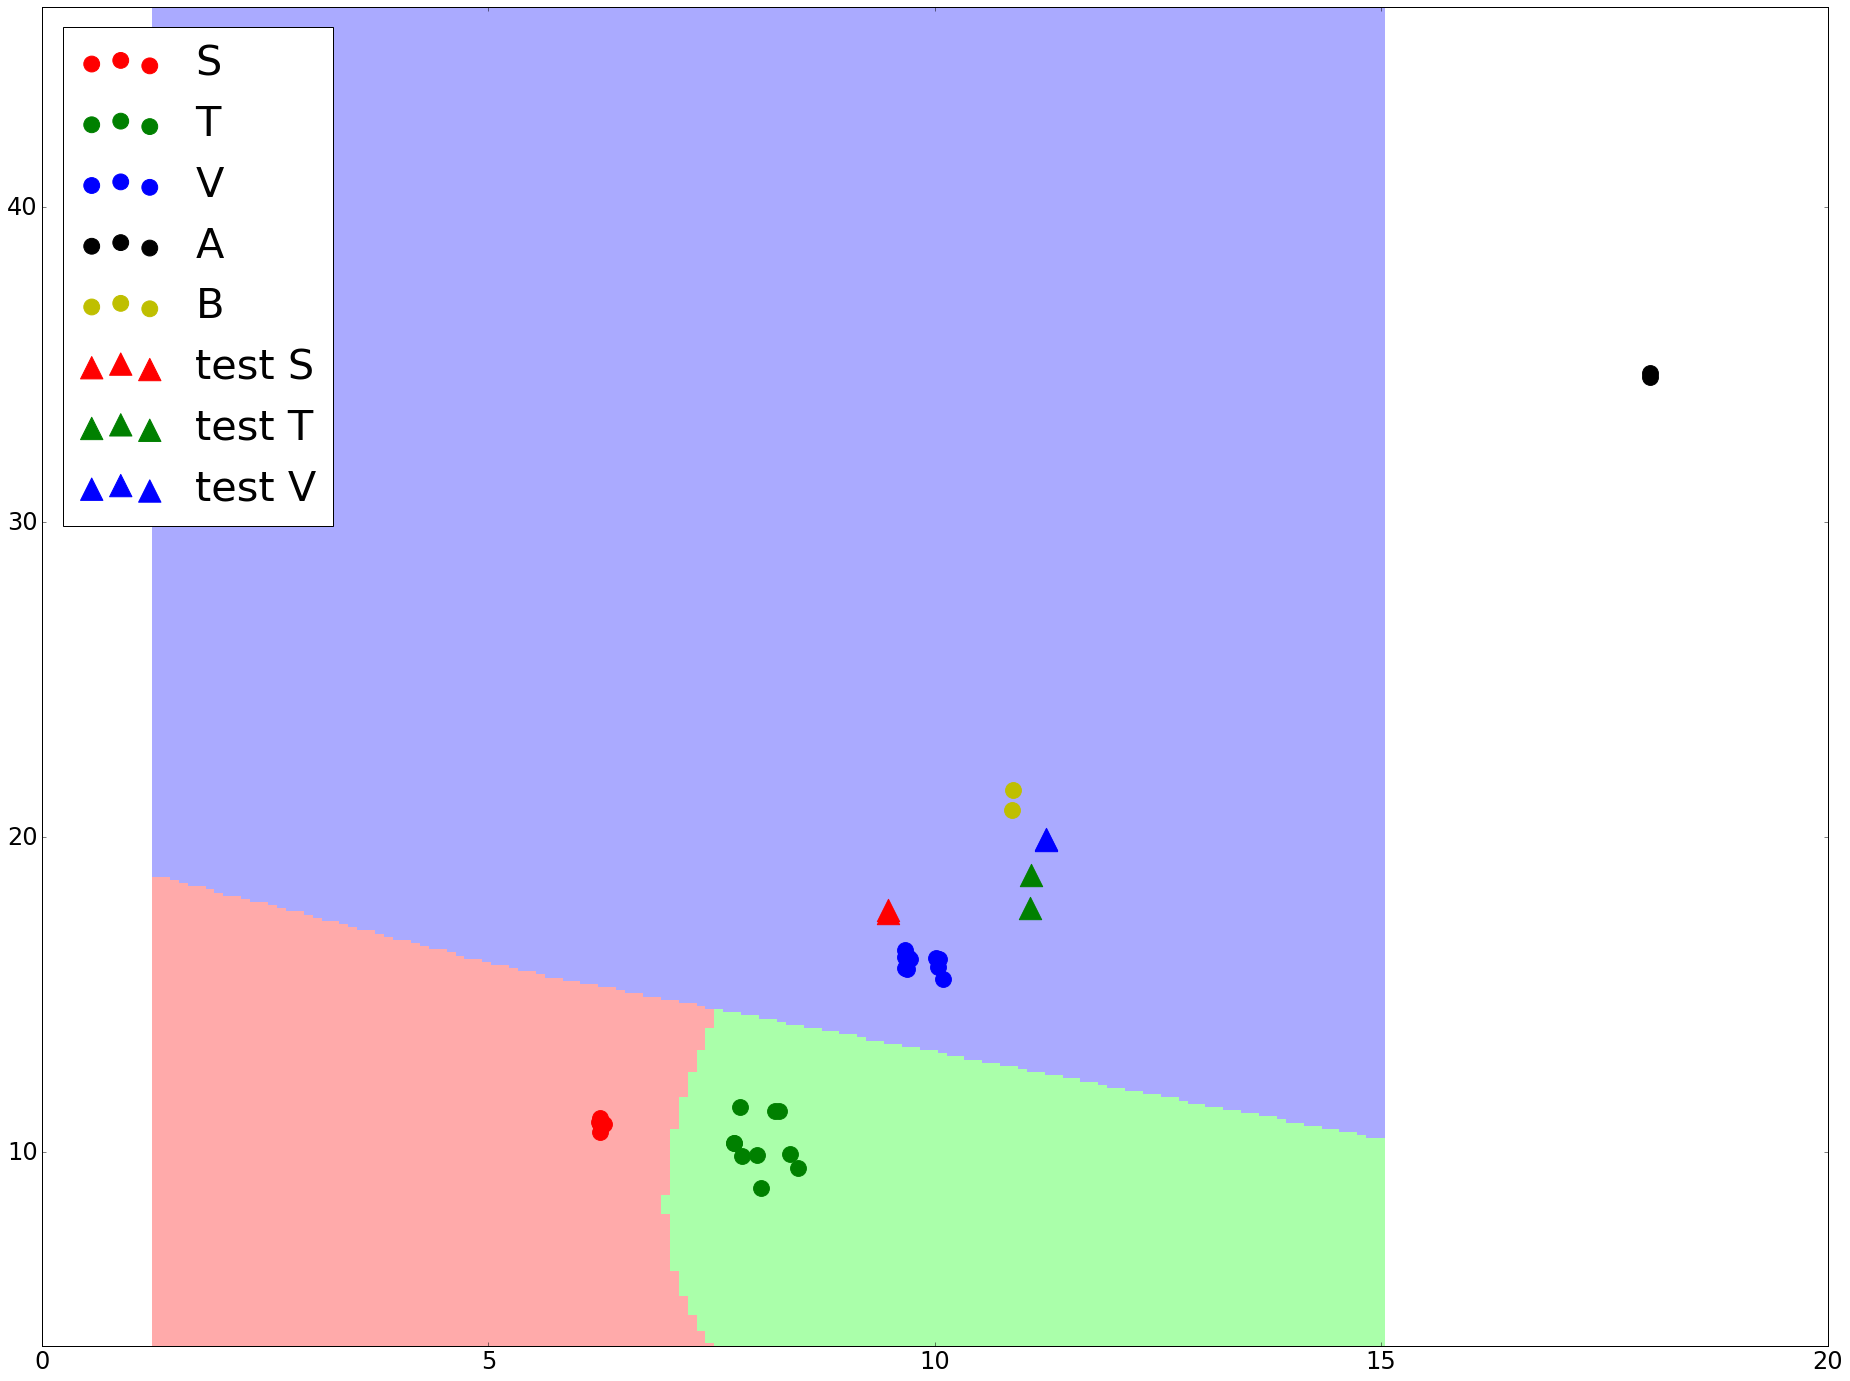

2


In [161]:
# Support Vector Machine with A and B

neighSVM = svm.SVC(kernel="poly", degree=2)
neighSVM.fit(dataInTuples, classes)

fig3 = plt.figure()
ax3 = fig3.add_subplot(111)
x_min, x_max = xvalues.min() - 5, xvalues.max() + 5
y_min, y_max = yvalues.min() - 5, yvalues.max() + 30
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
ZSVM = neighSVM.predict(np.c_[xx.ravel(), yy.ravel()])

cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])


# Put the result into a color plot
ZSVM = ZSVM.reshape(xx.shape)
plt.pcolormesh(xx, yy, ZSVM, cmap=cmap_light)

# Plot also the training points
ax3.scatter(feature1, feature2, s=250, color="r", label="S")
ax3.scatter(feature3, feature4, s=250, color="g", label="T")
ax3.scatter(feature5, feature6, s=250, color="b", label="V")
#ax3.scatter(testAfeature1, testAfeature2, s=250, color="k", label="A")
#ax3.scatter(testBfeature1, testBfeature2, s=250, color="y", label="B")

ax3.scatter(testSfeature1, testSfeature2, marker="^", s=500, color="r", label="test S")
ax3.scatter(testTfeature1, testTfeature2, marker="^", s=500, color="g", label="test T")
ax3.scatter(testVfeature1, testVfeature2,  marker="^", s=500, color="b", label="test V")

plt.ylim(yy.min(), yy.max())
ax3.legend(loc=2,fontsize = 'xx-large')
plt.show()

print(len(testSfeature1))